<a href="https://colab.research.google.com/github/soumitrapy/DeptEst/blob/main/playbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
# !git clone -b dev https://github.com/soumitrapy/DeptEst.git project
# %cd project
# from google.colab import drive
# drive.mount('/content/drive')
# !unzip -q '/content/drive/MyDrive/Colab Notebooks/ee5179.zip'

In [1]:
%matplotlib inline

In [4]:
import yaml
config = yaml.safe_load(open("config/default.yaml"))
config

{'project': 'DeptEst',
 'use_wandb': False,
 'dataset': {'name': 'CustomDataset',
  'root': './competition-data',
  'training-images': 'training-images',
  'training-depths': 'training-depths',
  'validation-images': 'validation-images',
  'validation-depths': 'validation-depths',
  'testing-images': 'testing-images',
  'img_size': 256,
  'batch_size': 10},
 'model': {'name': 'VIT',
  'n_encoder_layers': 8,
  'd_model': 256,
  'nhead': 8,
  'patch_size': 16},
 'train': {'epochs': 10, 'val_interval': 1}}

In [13]:
# config['dataset']['batch_size']=10
config['train']['epochs']=1
# #config['use_wandb']=True
config['model']['n_encoder_layers'] = 1
# a4ae227b893b7695d766727c3f4d4e630f69ce16
import wandb
if config.get('use_wandb',False):
    wandb.login()

In [14]:
from torchvision import transforms
from preprocessing import get_datasets_and_dataloaders

ds, dl = get_datasets_and_dataloaders(config)
ds, dl
for x,y in dl['train']:
    print(x.shape, y.shape)
    break

torch.Size([10, 1, 256, 256]) torch.Size([10, 1, 256, 256])


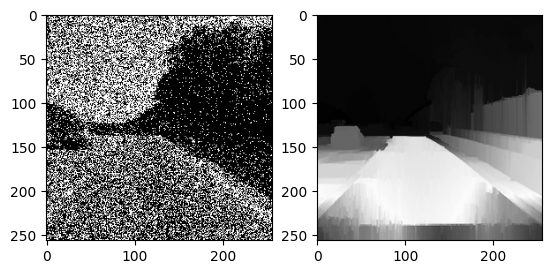

In [15]:
import numpy as np
import utils

idx = np.random.randint(len(ds['train']))
utils.show_images(idx = np.random.randint(len(ds['train'])), ds=ds['train'])

In [16]:
ds['train'][idx][0].shape

torch.Size([1, 256, 256])

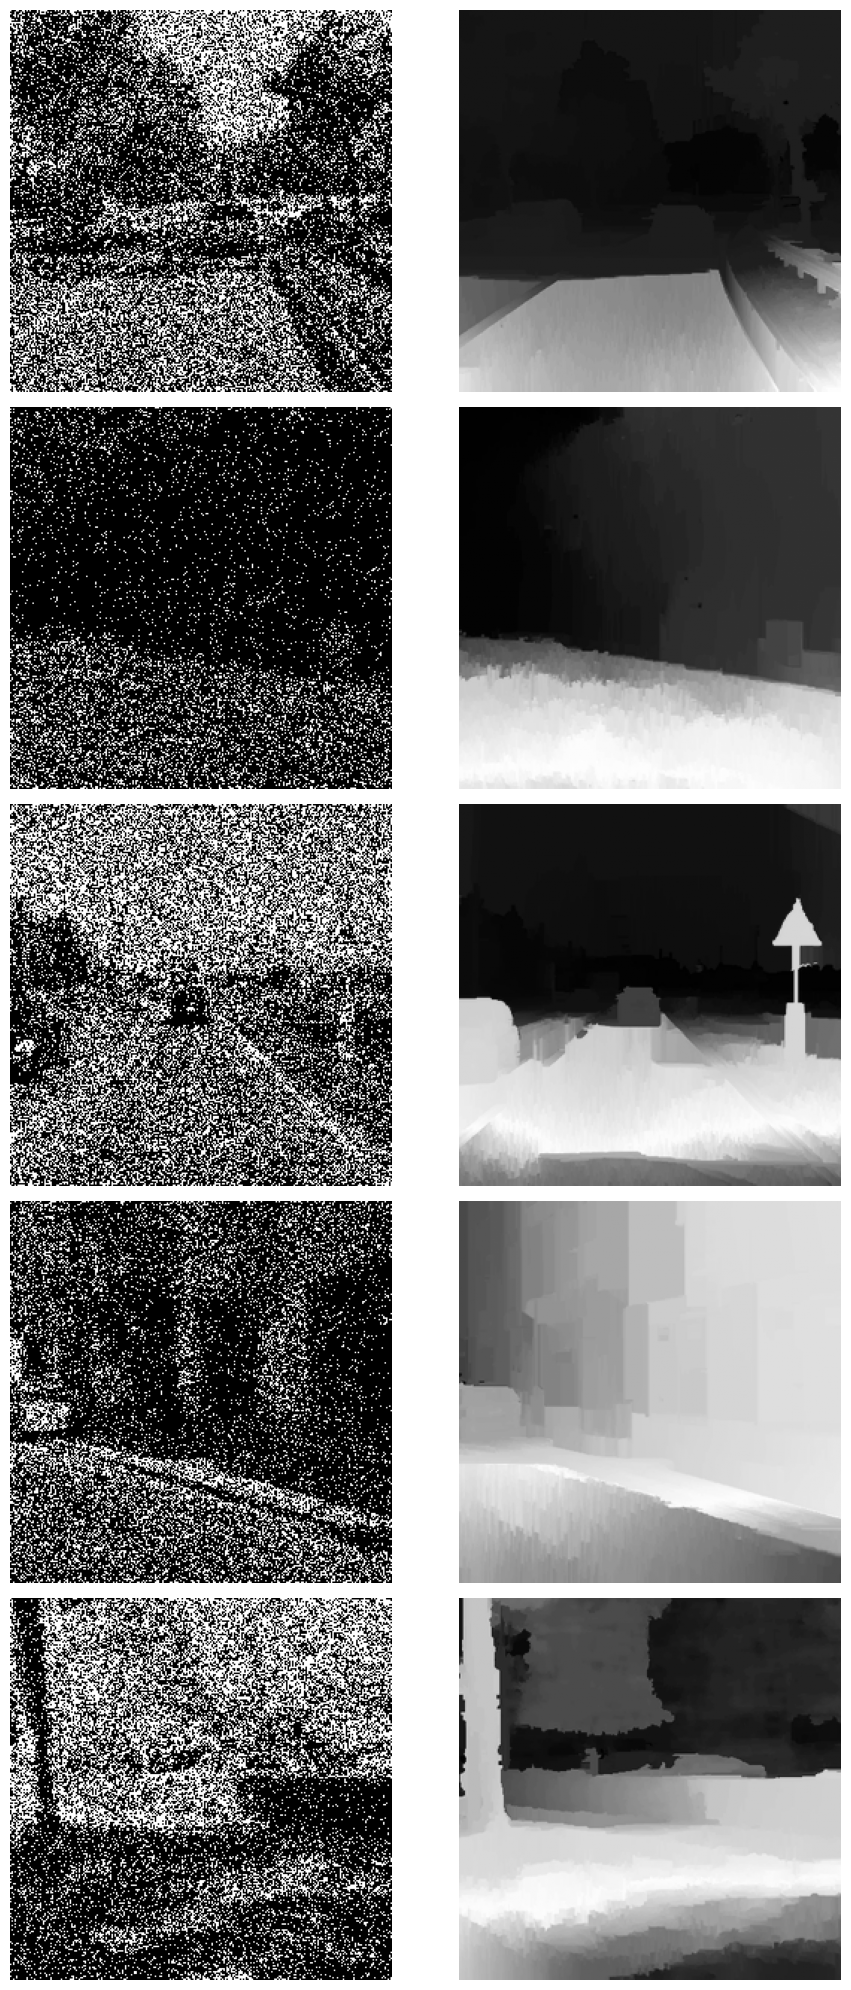

In [17]:
k = 5
utils.show_random_images(ds['train'],k=k, figsize=(k*2, k*4))

### Model and Other stafs

In [18]:
from importlib import reload
from models.vit import VIT
model = VIT(config)
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [19]:
import torch
from models import RMSELoss

#loss_fn = torch.nn.MSELoss()
loss_fn = RMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

### Training

In [ ]:
from train import train
from datetime import datetime
if config['use_wandb']:
    run_name = type(model).__name__+str(datetime.now())[8:18]
    wandb.init(
        project=config['project'],
        name = run_name,
        config=config['model'],
    )
train(model, optimizer, loss_fn, dl, config, scheduler = scheduler, device = device, use_wandb=config['use_wandb'])

Epoch 1:   3%|▎         | 22/669 [00:15<05:06,  2.11it/s, train_loss=1.13]

### Predictions

In [ ]:
from tqdm import tqdm
import torch
import os
from torchvision.transforms.functional import to_pil_image
from datetime import datetime
from imgs2csv import images_to_csv_with_metadata
from train import predict


# def predict(model, dl, device='cpu', dest = 'predictions', use_wandb=False):
#     model.to(device)
#     model.eval()
#     os.makedirs('predictions', exist_ok=True)
#     model_name = type(model).__name__+'_'+str(datetime.now())[8:16]
#     save_dir = os.path.join('predictions',model_name)
#     print(save_dir)
#     os.makedirs(save_dir)
#     pbar = tqdm(dl,desc=f"Predicting.... ")
#     with torch.no_grad():
#         for i, (inputs, image_names) in enumerate(pbar):
#             inputs = inputs.to(device)
#             im_names = [s.split('/')[-1] for s in image_names]
#             outputs = model(inputs)
#             for x,name in zip(outputs, im_names):
#                 img = to_pil_image(x)
#                 img.save(os.path.join(save_dir, name))

#     images_to_csv_with_metadata(save_dir, 'predictions/pred_'+model_name+'.csv')
predict(model, dl['test'], model_config = config['model'], device = device, use_wandb=False)

Predicting.... :   0%|          | 0/84 [00:09<?, ?it/s]

torch.Size([1, 256, 256]) 18053611.png
